In [5]:
import numpy as np
import mps
import tebd
import scipy
from tensornetwork import ncon
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [8]:
# Initialise 'empty' MPS
N = 30
chi = 17
d = 3
mps_tensors = [np.zeros((chi, d, chi)) for _ in range(N)]
weights = [np.ones((chi)) / np.sqrt(chi) for _ in range(N)]

# Set MPS to product state with one spin max in the center and all other spins min
for t in mps_tensors:
    t[:, d-1, :] = 1.0
mps_tensors[N // 2][:, d-1, :] = 0.0
mps_tensors[N // 2][:, 0, :] = 1.0

# Canonicalize MPS
sigmas = mps.left_environment_tensors(mps_tensors, weights)
mus = mps.right_environment_tensors(mps_tensors, weights)
mps_tensors, weights = mps.canonical_form(mps_tensors, weights, sigmas, mus)

In [11]:
delta = 0.01
T = 50
num_tsteps = int(T / delta)
num_midsteps = 5  # Number of timesteps between canonicalization and measurements
num_evolutions = num_tsteps // num_midsteps

# Compute time evolution gate
J = 1  # Nearest-neighbour coupling
B = 1  # External field
sx, sy, sz = tebd.generate_spin_operators(s=(d - 1) / 2)
nn_hamiltonian = -B * (np.kron(sz, np.eye(d)) + np.kron(np.eye(d), sz)) - J * (
    np.kron(sx, sx) + np.kron(sy, sy) + np.kron(sz, sz)
)
gate = scipy.linalg.expm(-1j * delta * nn_hamiltonian).reshape(d, d, d, d)

spin_expectations = np.zeros((num_evolutions, N))

for i in range(num_evolutions):
    print(i)
    # Evolve state in time
    mps_tensors, weights = tebd.do_tebd_timesteps(
        num_midsteps, gate, mps_tensors, weights, max_chi_trunc=17
    )

    # Canonicalize MPS and find spin expectation values
    sigmas = mps.left_environment_tensors(mps_tensors, weights)
    mus = mps.right_environment_tensors(mps_tensors, weights)
    mps_tensors, weights = mps.canonical_form(mps_tensors, weights, sigmas, mus)
    spin_expectations[i] = mps.one_body_gate_expectation_values(
        sz, mps_tensors, weights
    )
    clear_output(wait=True)


999


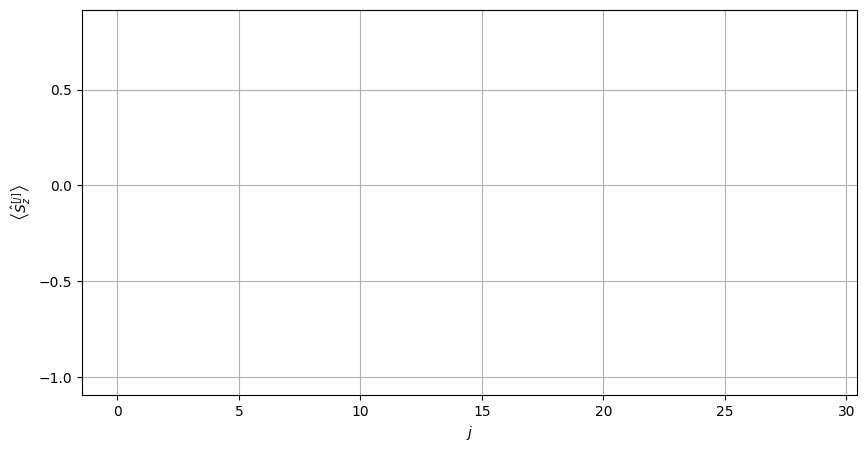

In [13]:
# Generate animation showing spin wave propagation
fig, ax0 = plt.subplots(figsize=(10, 5))
ax0.grid()
ax0.set_xlabel('$j$')
ax0.set_ylabel(r'$\left\langle \hat{S}_z^{[j]}\right\rangle$')
s = (d - 1) / 2
ax0.set_yticks(np.linspace(-s, s, 5))

artists = []
for i in range(num_tsteps//5):
    artist = ax0.plot(np.arange(N), spin_expectations[i], '.k')
    artists.append(artist)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=25)
# ani.save('./videos/spin_one_wave.mp4', writer='ffmpeg')